In [82]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
df = pd.read_csv('datasets/combined_with_who.csv')

In [7]:
df['label'].value_counts()

false         6315
true          2930
misleading    1159
Name: label, dtype: int64

In [8]:
df.isnull().sum()

label    0
text     0
dtype: int64

### Sentiment Analysis

In [57]:
positive_words = ['brave','great', 'improve',
                  'amazing','decrease','strong','safe', 'clean',
                  'happy','love', 'enjoy','accomplish','achieve',
                  'good', 'negative', 'cure', 'support','effective','save', 'open']
negative_words = ['infected','violence','terrible','worse','death','fake', 'illegal',
                  'destroy', 'aggresive','enemy','crash',
                  'bad','false','rude','disappointed','positive','crisis','increase']

In [58]:
def pos_sentiment(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(word) for word in tokens]
    positive_stems = [p_stemmer.stem(word) for word in positive_words]
    return sum([1 for i in stemmed_words if i in positive_stems])/ len(stemmed_words)

In [59]:
def neg_sentiment(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(word) for word in tokens]
    negative_stems = [p_stemmer.stem(word) for word in negative_words]
    return sum([1 for i in stemmed_words if i in negative_stems])/ len(stemmed_words)

In [60]:
pos = []
neg = []
for post in df['text']:
    pos_scores = pos_sentiment(post)
    neg_scores = neg_sentiment(post)
    pos.append(pos_scores)
    neg.append(neg_scores)

In [61]:
sentiment = pd.DataFrame({'pos': pos, 'neg': neg})

In [62]:
sentiment_df = pd.concat([df, sentiment], axis=1)

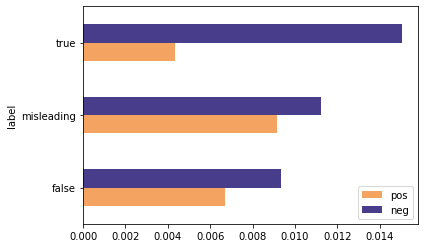

In [63]:
sentiment_df.groupby('label').mean()[['pos', 'neg']].plot(kind = 'barh', color = colors)

In [30]:
sia = SentimentIntensityAnalyzer()

In [31]:
dicts = []
for post in df['text']:
    scores = sia.polarity_scores(post)
    dicts.append(scores)

scores = pd.DataFrame(dicts)
scores.head()

,neg,neu,pos,compound
0,0.167,0.517,0.316,0.3818
1,0.164,0.656,0.180,0.0516
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.000,0.743,0.257,0.5423


In [33]:
vader_df = pd.concat([df, scores], axis=1)

In [36]:
colors = pos_neg.columns.map({'pos': '#F4A460', 'neg': '#483D8B'})

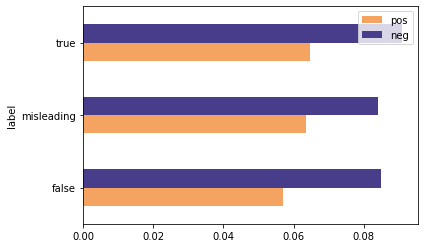

In [37]:
vader_df.groupby('label').mean()[['pos', 'neg']].plot(kind = 'barh', color = colors)

### Model

In [47]:
X = df['text']
y = df['label']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [64]:
pipe_bag = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier() )
])

In [77]:
bag_params = {
    'cvec__ngram_range': [(1,1),(1, 2)],
    'cvec__stop_words': [None, 'english']
}

In [78]:
gs_bag = GridSearchCV(pipe_bag, bag_params, cv =5)

In [79]:
gs_bag.fit(X_train, y_train)

KeyboardInterrupt: 

In [75]:
gs_bag.score(X_test, y_test)

0.750480584390619

In [76]:
gs_bag.score(X_train, y_train)

0.9605280020504934

In [94]:
pipe_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
])

In [100]:
ada_params = {
    'ada__n_estimators': [50,100],
    'ada__base_estimator__max_depth': [1,2],
    'ada__learning_rate': [.9, 1.0]
}

In [101]:
ada_gs = GridSearchCV(pipe_ada, param_grid=ada_params, cv=3)

In [102]:
ada_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [103]:
ada_gs.score(X_test, y_test)

0.7304882737408689

In [104]:
ada_gs.score(X_train, y_train)

0.7515058310906062

In [105]:
ada_gs.best_params_

{'ada__base_estimator__max_depth': 2,
 'ada__learning_rate': 0.9,
 'ada__n_estimators': 50}